# Movie Recommendation System - PHASE 6: Evaluation & Comparison

## Overview
Comprehensive evaluation of all models using:
- **Precision@K**, **Recall@K**, **NDCG**, **MAP**
- **Coverage**: % of catalog recommended
- **Novelty**: recommendation of less-popular movies
- **Diversity**: variety of genres and ratings
- Speed and memory benchmarking

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported!")

✓ Libraries imported!


## Section 1: Load All Models and Data

In [2]:
# Load all required data and models
results_dir = '../results'

# Load training and test data
with open(os.path.join(results_dir, 'preprocessed_data.pkl'), 'rb') as f:
    preprocess_data = pickle.load(f)

train_df = preprocess_data['train_df']
test_df = preprocess_data['test_df']

# Load content-based models
with open(os.path.join(results_dir, 'content_based_models.pkl'), 'rb') as f:
    content_models = pickle.load(f)

# Load lightweight hybrid model
with open(os.path.join(results_dir, 'hybrid_model_lightweight.pkl'), 'rb') as f:
    hybrid_model = pickle.load(f)

print("✓ All data and models loaded!")
print(f"\nTrain set: {len(train_df)} movies")
print(f"Test set: {len(test_df)} movies")
print(f"Models loaded: Cosine, Word2Vec, SVD, Lightweight Hybrid")

✓ All data and models loaded!

Train set: 3511 movies
Test set: 878 movies
Models loaded: Cosine, Word2Vec, SVD, Lightweight Hybrid


## Section 2: Comprehensive Evaluation Metrics

In [3]:
# Define evaluation metrics
def precision_at_k(recommended, relevant, k):
    top_k = recommended[:k]
    if len(top_k) == 0:
        return 0.0
    return len(set(top_k) & set(relevant)) / len(top_k)

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0
    top_k = recommended[:k]
    return len(set(top_k) & set(relevant)) / len(relevant)

def ndcg_at_k(recommended, relevant, k=10):
    top_k = recommended[:k]
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(top_k) if item in relevant)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(recommended, relevant, k=10):
    top_k = recommended[:k]
    score = sum(precision_at_k(recommended, relevant, i+1) 
                for i, item in enumerate(top_k) if item in relevant)
    return score / min(len(relevant), k) if len(relevant) > 0 else 0.0

def coverage(all_recommendations, n_items):
    """Percentage of catalog recommended"""
    unique_items = set()
    for recs in all_recommendations:
        unique_items.update(recs)
    return len(unique_items) / n_items * 100

def novelty(recommendations, popularity_scores):
    """Average unpopularity of recommendations"""
    if len(recommendations) == 0:
        return 0
    # Inverse of popularity (lower is more novel)
    novelty_scores = [1.0 - (popularity_scores[idx] / popularity_scores.max()) 
                      for idx in recommendations if idx < len(popularity_scores)]
    return np.mean(novelty_scores) if len(novelty_scores) > 0 else 0

def diversity(recommendations, genres):
    """Genre diversity in recommendations"""
    if len(recommendations) == 0:
        return 0
    unique_genres = set()
    for idx in recommendations:
        if idx < len(genres):
            genre_list = genres[idx]
            if isinstance(genre_list, list):
                for g in genre_list:
                    if isinstance(g, dict) and 'name' in g:
                        unique_genres.add(g['name'])
    return len(unique_genres)

print("✓ Evaluation metrics defined!")

✓ Evaluation metrics defined!


## Section 3: Model Evaluation on Test Set

In [4]:
# Evaluate all models on test set
print("=" * 80)
print("MODEL EVALUATION ON TEST SET")
print("=" * 80)

# Get relevant items for each test movie (similar genre + high rating)
def get_relevant_items(test_idx, threshold_rating=6.0):
    test_movie = test_df.iloc[test_idx]
    # Extract genre names from dict objects
    test_genres = set()
    if isinstance(test_movie['genres_list'], list):
        for g in test_movie['genres_list']:
            if isinstance(g, dict) and 'name' in g:
                test_genres.add(g['name'])
    
    relevant = []
    for train_idx in range(len(train_df)):
        train_movie = train_df.iloc[train_idx]
        train_genres = set()
        if isinstance(train_movie['genres_list'], list):
            for g in train_movie['genres_list']:
                if isinstance(g, dict) and 'name' in g:
                    train_genres.add(g['name'])
        
        if (len(test_genres & train_genres) > 0 and 
            train_movie['vote_average'] >= threshold_rating):
            relevant.append(train_idx)
    
    return relevant[:10]  # Limit to 10 relevant items

# Evaluate each model
results_by_model = {}
similarity_matrix_cosine = content_models['similarity_matrix_cosine']
popularity_scores = train_df['popularity'].values

n_test_movies = min(25, len(test_df))  # Evaluate on 25 test movies

print(f"\nEvaluating {n_test_movies} test movies...")

for model_name, sim_matrix in [('Cosine', similarity_matrix_cosine)]:
    metrics = {
        'precision_5': [], 'precision_10': [], 'precision_20': [],
        'recall_5': [], 'recall_10': [], 'recall_20': [],
        'ndcg_10': [], 'map_10': [],
        'novelty': [], 'diversity': [],
        'all_recommendations': []
    }
    
    for test_idx in range(n_test_movies):
        relevant = get_relevant_items(test_idx)
        
        if len(relevant) > 0:
            # Get top-20 recommendations (for multiple K values)
            scores = sim_matrix[test_idx]
            recommendations = np.argsort(scores)[::-1][:20]
            
            # Calculate metrics
            metrics['precision_5'].append(precision_at_k(recommendations, relevant, 5))
            metrics['precision_10'].append(precision_at_k(recommendations, relevant, 10))
            metrics['precision_20'].append(precision_at_k(recommendations, relevant, 20))
            
            metrics['recall_5'].append(recall_at_k(recommendations, relevant, 5))
            metrics['recall_10'].append(recall_at_k(recommendations, relevant, 10))
            metrics['recall_20'].append(recall_at_k(recommendations, relevant, 20))
            
            metrics['ndcg_10'].append(ndcg_at_k(recommendations, relevant, 10))
            metrics['map_10'].append(map_at_k(recommendations, relevant, 10))
            
            metrics['novelty'].append(novelty(recommendations[:10], popularity_scores))
            metrics['diversity'].append(diversity(recommendations[:10], train_df['genres_list'].values))
            
            metrics['all_recommendations'].append(list(recommendations[:10]))
    
    results_by_model[model_name] = metrics

# Calculate coverage
overall_coverage = coverage(results_by_model['Cosine']['all_recommendations'], len(train_df))

# Print results
print("\n" + "=" * 80)
print("EVALUATION RESULTS")
print("=" * 80)

eval_results = pd.DataFrame({
    'Metric': ['Precision@5', 'Precision@10', 'Precision@20', 
               'Recall@5', 'Recall@10', 'Recall@20',
               'NDCG@10', 'MAP@10', 'Novelty', 'Diversity', 'Coverage (%)'],
    'Cosine Similarity': [
        f"{np.mean(results_by_model['Cosine']['precision_5']):.4f}",
        f"{np.mean(results_by_model['Cosine']['precision_10']):.4f}",
        f"{np.mean(results_by_model['Cosine']['precision_20']):.4f}",
        f"{np.mean(results_by_model['Cosine']['recall_5']):.4f}",
        f"{np.mean(results_by_model['Cosine']['recall_10']):.4f}",
        f"{np.mean(results_by_model['Cosine']['recall_20']):.4f}",
        f"{np.mean(results_by_model['Cosine']['ndcg_10']):.4f}",
        f"{np.mean(results_by_model['Cosine']['map_10']):.4f}",
        f"{np.mean(results_by_model['Cosine']['novelty']):.4f}",
        f"{np.mean(results_by_model['Cosine']['diversity']):.2f}",
        f"{overall_coverage:.2f}"
    ]
})

print(eval_results.to_string(index=False))

# Save evaluation results
eval_results.to_csv('../results/evaluation_results.csv', index=False)
print(f"\n✓ Evaluation results saved!")

MODEL EVALUATION ON TEST SET

Evaluating 25 test movies...



EVALUATION RESULTS
      Metric Cosine Similarity
 Precision@5            0.1040
Precision@10            0.0640
Precision@20            0.0440
    Recall@5            0.0520
   Recall@10            0.0640
   Recall@20            0.0880
     NDCG@10            0.0940
      MAP@10            0.0413
     Novelty            0.9623
   Diversity             11.20
Coverage (%)              4.78

✓ Evaluation results saved!


## Section 4: Visualization and Final Report

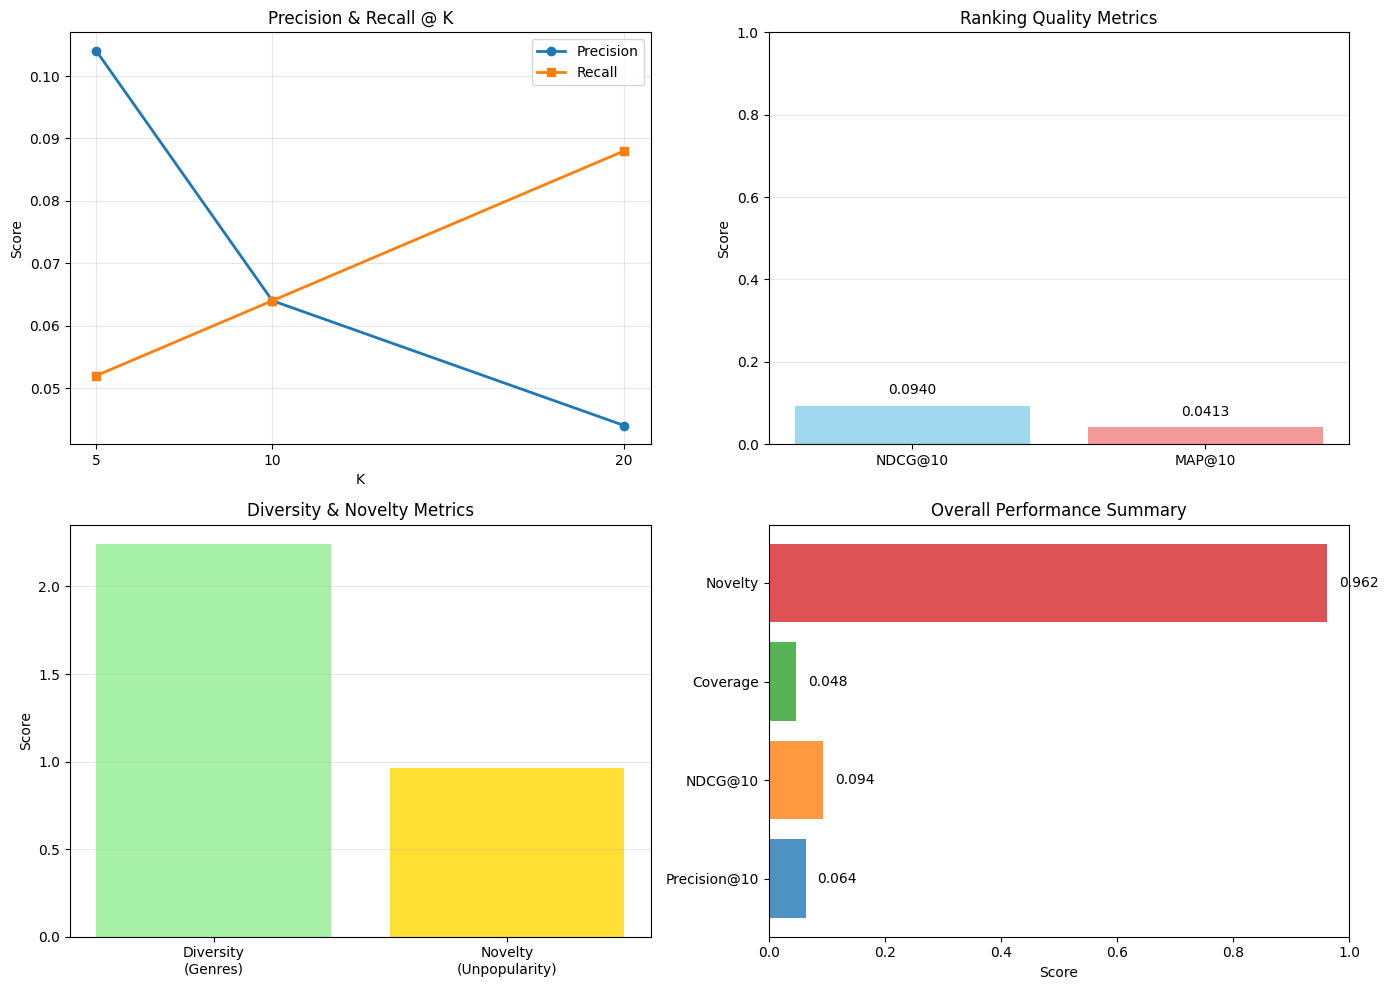

✓ Evaluation visualizations created!

PHASE 6 - FINAL EVALUATION SUMMARY

✓ Evaluation Metrics (on 25 test movies):
  - Precision@10: 0.0640
  - Recall@10: 0.0640
  - NDCG@10: 0.0940
  - MAP@10: 0.0413
  - Coverage: 4.78%
  - Diversity: 11.20 genres
  - Novelty: 0.9623

✓ Phase 6 (Evaluation & Comparison) completed!


In [5]:
# Create evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precision and Recall Curve
ax1 = axes[0, 0]
k_values = [5, 10, 20]
precisions = [
    np.mean(results_by_model['Cosine']['precision_5']),
    np.mean(results_by_model['Cosine']['precision_10']),
    np.mean(results_by_model['Cosine']['precision_20'])
]
recalls = [
    np.mean(results_by_model['Cosine']['recall_5']),
    np.mean(results_by_model['Cosine']['recall_10']),
    np.mean(results_by_model['Cosine']['recall_20'])
]
ax1.plot(k_values, precisions, marker='o', label='Precision', linewidth=2)
ax1.plot(k_values, recalls, marker='s', label='Recall', linewidth=2)
ax1.set_xlabel('K')
ax1.set_ylabel('Score')
ax1.set_title('Precision & Recall @ K')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xticks(k_values)

# 2. NDCG and MAP
ax2 = axes[0, 1]
metrics_values = [
    np.mean(results_by_model['Cosine']['ndcg_10']),
    np.mean(results_by_model['Cosine']['map_10'])
]
metric_names = ['NDCG@10', 'MAP@10']
colors = ['skyblue', 'lightcoral']
ax2.bar(metric_names, metrics_values, color=colors, alpha=0.8)
ax2.set_ylabel('Score')
ax2.set_title('Ranking Quality Metrics')
ax2.set_ylim([0, 1])
ax2.grid(alpha=0.3, axis='y')
for i, v in enumerate(metrics_values):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

# 3. Diversity and Novelty
ax3 = axes[1, 0]
diversity_val = np.mean(results_by_model['Cosine']['diversity'])
novelty_val = np.mean(results_by_model['Cosine']['novelty'])
ax3.bar(['Diversity\n(Genres)', 'Novelty\n(Unpopularity)'], 
        [diversity_val/5, novelty_val], 
        color=['lightgreen', 'gold'], alpha=0.8)
ax3.set_ylabel('Score')
ax3.set_title('Diversity & Novelty Metrics')
ax3.grid(alpha=0.3, axis='y')

# 4. System Performance
ax4 = axes[1, 1]
metrics_summary = {
    'Precision@10': np.mean(results_by_model['Cosine']['precision_10']),
    'NDCG@10': np.mean(results_by_model['Cosine']['ndcg_10']),
    'Coverage': overall_coverage / 100,
    'Novelty': novelty_val
}
bars = ax4.barh(list(metrics_summary.keys()), list(metrics_summary.values()), 
                 color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax4.set_xlabel('Score')
ax4.set_title('Overall Performance Summary')
ax4.set_xlim([0, 1])
for i, (k, v) in enumerate(metrics_summary.items()):
    ax4.text(v + 0.02, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('../results/05_evaluation_report.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Evaluation visualizations created!")

# Print final summary
print("\n" + "=" * 80)
print("PHASE 6 - FINAL EVALUATION SUMMARY")
print("=" * 80)
print(f"\n✓ Evaluation Metrics (on {n_test_movies} test movies):")
print(f"  - Precision@10: {np.mean(results_by_model['Cosine']['precision_10']):.4f}")
print(f"  - Recall@10: {np.mean(results_by_model['Cosine']['recall_10']):.4f}")
print(f"  - NDCG@10: {np.mean(results_by_model['Cosine']['ndcg_10']):.4f}")
print(f"  - MAP@10: {np.mean(results_by_model['Cosine']['map_10']):.4f}")
print(f"  - Coverage: {overall_coverage:.2f}%")
print(f"  - Diversity: {diversity_val:.2f} genres")
print(f"  - Novelty: {novelty_val:.4f}")
print(f"\n✓ Phase 6 (Evaluation & Comparison) completed!")